<a href="https://colab.research.google.com/github/mcytrynbaum/EconML/blob/main/pgmpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAGs: D-Separation and Conditonal Independencies, Adjustment via Backdoor and Swigs, Equivalence Classes, Falsifiability Tests.


In [ ]:
!pip install pgmpy

In [ ]:
import warnings
warnings.simplefilter('ignore')

# Graph Generation and Plotting

The following DAG is due to Judea Pearl

In [ ]:
import networkx as nx

digraph = nx.DiGraph([('Z1','X1'),
                    ('X1','D'),
                    ('Z1','X2'),
                    ('Z2','X3'),
                    ('X3','Y'),
                    ('Z2','X2'),
                    ('X2', 'Y'),
                    ('X2', 'D'),
                    ('M', 'Y'),
                    ('D', 'M')])

In [ ]:
from pgmpy.base.DAG import DAG

G = DAG(digraph)

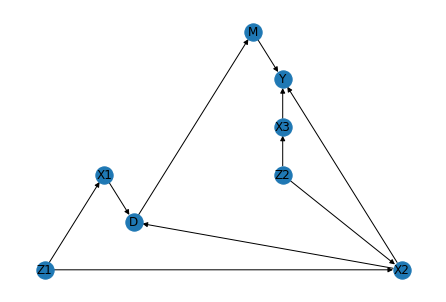

In [ ]:
import pylab as plt

nx.draw_planar(G, with_labels=True)
plt.show()

In [ ]:
print(list(G.predecessors("X2")))
print(list(G.successors("X2")))
print(list(nx.ancestors(G, "X2")))
print(list(nx.descendants(G, "X2")))

['Z1', 'Z2']
['Y', 'D']
['Z2', 'Z1']
['D', 'M', 'Y']


# Find Paths Between D and Y




In [ ]:
list(nx.all_simple_paths(G.to_undirected(), "D", "Y"))

[['D', 'X1', 'Z1', 'X2', 'Y'],
 ['D', 'X1', 'Z1', 'X2', 'Z2', 'X3', 'Y'],
 ['D', 'M', 'Y'],
 ['D', 'X2', 'Y'],
 ['D', 'X2', 'Z2', 'X3', 'Y']]

# List All Testable Implications of the Model

Here we use D-separation to list all the conditional independence relations deduced from the DAG.

In [ ]:
# these returns all conditional independencies even among two sets of variables
# conditional on a third set
dseps = G.get_independencies()

In [ ]:
# we display only the ones that correpond to pairs of singletons
for dsep in dseps.get_assertions():
    if len(dsep.get_assertion()[1])==1:
        print(dsep)

(Y ⟂ Z1 | Z2, X2, X1)
(Y ⟂ D | X2, X1, M)
(Y ⟂ X1 | X2, D, Z1)
(Y ⟂ Z2 | X2, X3, Z1)
(Y ⟂ Z1 | D, Z2, X2, X1)
(Y ⟂ Z1 | X3, Z2, X2, X1)
(Y ⟂ X1 | Z2, D, X2, Z1)
(Y ⟂ D | X2, X1, M, Z1)
(Y ⟂ Z2 | X3, X2, X1, Z1)
(Y ⟂ X1 | X2, D, M, Z1)
(Y ⟂ Z1 | X2, Z2, X1, M, D)
(Y ⟂ D | X2, Z2, X1, M, Z1)
(Y ⟂ Z1 | X2, X3, Z2, X1, D)
(Y ⟂ X1 | X2, Z2, M, D, Z1)
(Y ⟂ X1 | X2, X3, Z2, D, Z1)
(Y ⟂ Z2 | X2, X3, X1, D, Z1)
(Y ⟂ Z1 | X2, X3, Z2, X1, M, D)
(Y ⟂ D | X2, X3, Z2, X1, M, Z1)
(Y ⟂ X1 | X2, X3, Z2, M, D, Z1)
(Y ⟂ Z2 | X2, X3, X1, M, D, Z1)
(X2 ⟂ X3 | Z2)
(X2 ⟂ M | D)
(X2 ⟂ X1 | Z1)
(X2 ⟂ X3 | Z2, X1)
(X2 ⟂ X3 | Z2, M)
(X2 ⟂ M | D, X1)
(X2 ⟂ M | D, X3)
(X2 ⟂ M | D, Z1)
(X2 ⟂ X1 | X3, Z1)
(X2 ⟂ X3 | Z2, X1, M)
(X2 ⟂ X3 | Z2, X1, Z1)
(X2 ⟂ X3 | Z2, D, M)
(X2 ⟂ X3 | Z2, M, Z1)
(X2 ⟂ M | Z2, D, X3)
(X2 ⟂ X1 | Z2, X3, Z1)
(X2 ⟂ M | X3, D, X1)
(X2 ⟂ M | D, X1, Z1)
(X2 ⟂ M | D, X3, Z1)
(X2 ⟂ X3 | Z2, D, X1, M)
(X2 ⟂ X3 | Z2, X1, M, Z1)
(X2 ⟂ M | X3, Z2, D, X1)
(X2 ⟂ X3 | Z2, D, M, Z1)
(X2 ⟂ M | Z2, D, X3,

# Backdoor and frontdoor adjustments between D and Y

In [ ]:
from pgmpy.models.BayesianModel import BayesianNetwork
from pgmpy.inference.CausalInference import CausalInference

inference = CausalInference(BayesianNetwork(G))

In [ ]:
inference.get_all_backdoor_adjustment_sets('D', 'Y')

frozenset({frozenset({'X2', 'X3'}),
           frozenset({'X1', 'X2'}),
           frozenset({'X2', 'Z2'}),
           frozenset({'X2', 'Z1'})})

In [ ]:
inference.get_all_frontdoor_adjustment_sets('D', 'Y')

frozenset({frozenset({'M'})})

In [ ]:
inference.get_minimal_adjustment_set('D', 'Y')

{'X1', 'X2'}

In [ ]:
inference.is_valid_backdoor_adjustment_set('D', 'Y', 'X2')

False

# Testing DAG Validity by Checking Implied Conditional Independencies with DoWhy-GCM

We found all the implied conditional independence relations above. Can we test them?  The answer is yes, and is particularly simple if the DAG is associated with a liner SEM.

To illustrate, we simulate the data from a Linear SEM associated to DAG G, and perform a test of conditional independence restrictions, using a kernel based test.

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install dowhy

In [ ]:
# generate data from the SCM
import numpy as np
import pandas as pd

def gen_data(n):
    Z1 = np.random.normal(0, 1, size=n)
    Z2 = np.random.normal(0, 1, size=n)
    X1 = Z1 + np.random.normal(0, 1, size=n)
    X2 = Z1 + Z2 + np.random.normal(0, 1, size=n)
    X3 = Z2 + np.random.normal(0, 1, size=n)
    D = X1 + X2 + np.random.normal(0, 1, size=n)
    M = D + np.random.normal(0, 1, size=n)
    Y = M + X2 + X3 + np.random.normal(0, 1, size=n)
    return pd.DataFrame({'Z1': Z1, 'Z2': Z2, 'X1': X1, 'X2': X2, 'X3': X3, 'D': D, 'M': M, 'Y': Y})

In [ ]:
data = gen_data(5000)

In [ ]:
import dowhy.gcm as gcm
from dowhy.gcm.independence_test import kernel_based, regression_based

causal_model = gcm.StructuralCausalModel(digraph)
rej = gcm.refute_causal_structure(causal_model.graph, data, conditional_independence_test=kernel_based)

The rejection result contains two types of tests:
- local markov tests: that test whether any node is independent of its non-descendants conditional on its parents (these also imply global markov conditions)
- edge dependence tests: these test that the edges that were included in the graph carry sufficient amount of correlation.

In our case, we will only be focusing on the local markov tests. So we will reject the graph if any of the local markov tests fails, but we will ignore the other tests.

In [ ]:
rej

(<RejectionResult.NOT_REJECTED: (<enum.auto object at 0x7f04039e4400>,)>,
 {'Z1': {'local_markov_test': {}, 'edge_dependence_test': {}},
  'X1': {'local_markov_test': {'p_value': 0.14584789578377788,
    'fdr_adjusted_p_value': 0.2121423938673133,
    'success': True},
   'edge_dependence_test': {'Z1': {'p_value': 0.0,
     'fdr_adjusted_p_value': 0.0,
     'success': True}}},
  'D': {'local_markov_test': {'p_value': 0.9163864688377924,
    'fdr_adjusted_p_value': 0.9163864688377924,
    'success': True},
   'edge_dependence_test': {'X1': {'p_value': 0.0,
     'fdr_adjusted_p_value': 0.0,
     'success': True},
    'X2': {'p_value': 0.0, 'fdr_adjusted_p_value': 0.0, 'success': True}}},
  'X2': {'local_markov_test': {'p_value': 0.27298801407907614,
    'fdr_adjusted_p_value': 0.3639840187721015,
    'success': True},
   'edge_dependence_test': {'Z1': {'p_value': 0.0,
     'fdr_adjusted_p_value': 0.0,
     'success': True},
    'Z2': {'p_value': 0.0, 'fdr_adjusted_p_value': 0.0, 'success

Next we replaced $D$ by $\bar D$ generated differently:
$$
\bar D= (D + Y)/2
$$
So basically $\bar D$ is an average of $D$ and $Y$ generated by $D$.  We then test if the resulting collection of random variables satisifes conditional indepdendence restrictions, exploiting linearity.  We end up rejectiong these restrictions and thefore the validity of this model for the data generated in this way.  This makes sense, because the new data no longer obeys the previous DAG structure.



In [ ]:
data['D'] = (data['D'] + data['Y'])/2

In [ ]:
rej = gcm.refute_causal_structure(causal_model.graph, data, conditional_independence_test=kernel_based)

In [ ]:
rej

(<RejectionResult.REJECTED: 1>,
 {'Z1': {'local_markov_test': {}, 'edge_dependence_test': {}},
  'X1': {'local_markov_test': {'p_value': 0.5772659331444525,
    'fdr_adjusted_p_value': 0.615750328687416,
    'success': True},
   'edge_dependence_test': {'Z1': {'p_value': 0.0,
     'fdr_adjusted_p_value': 0.0,
     'success': True}}},
  'D': {'local_markov_test': {'p_value': 0.0,
    'fdr_adjusted_p_value': 0.0,
    'success': False},
   'edge_dependence_test': {'X1': {'p_value': 0.0,
     'fdr_adjusted_p_value': 0.0,
     'success': True},
    'X2': {'p_value': 0.0, 'fdr_adjusted_p_value': 0.0, 'success': True}}},
  'X2': {'local_markov_test': {'p_value': 0.7146891102032591,
    'fdr_adjusted_p_value': 0.7146891102032591,
    'success': True},
   'edge_dependence_test': {'Z1': {'p_value': 0.0,
     'fdr_adjusted_p_value': 0.0,
     'success': True},
    'Z2': {'p_value': 0.0, 'fdr_adjusted_p_value': 0.0, 'success': True}}},
  'Z2': {'local_markov_test': {}, 'edge_dependence_test': {}},

# Identification with Front-Door and DoWhy

In [ ]:
data = gen_data(5000)

In [ ]:
import dowhy

causal_graph = """digraph {
Z1; Z2; X1; X2; X3; D; M; Y;
Z1 -> X1;
X1 -> D;
Z1 -> X2;
Z2 -> X3;
X3 -> Y;
Z2 -> X2;
X2 -> Y;
X2 -> D;
M -> Y;
D -> M;
}"""

In [ ]:
cm = dowhy.CausalModel(data = data,
        treatment='D',
        outcome='Y',
        graph=causal_graph)

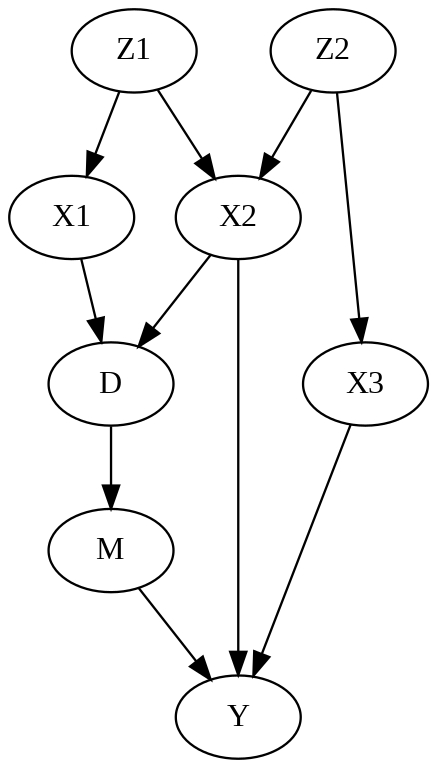

In [ ]:
from PIL import Image

cm.view_model(file_name='dag')
Image.open('dag.png')

In [ ]:
# method seems not to be doing false discovery rate (multiple testing/joint inference) control
# some tests might fail because of that when k is large (k=size of conditioning set)
print(cm.refute_graph(k=2))

Method name for discrete data:conditional_mutual_information
Method name for continuous data:partial_correlation
Number of conditional independencies entailed by model:55
Number of independences satisfied by data:46
Test passed:False



In [ ]:
identified_estimand = cm.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d              
────(E[Y|X2,Z2])
d[D]            
Estimand assumption 1, Unconfoundedness: If U→{D} and U→Y then P(Y|D,X2,Z2,U) = P(Y|D,X2,Z2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([M])⎥
 ⎣d[M]    d[D]     ⎦
Estimand assumption 1, Full-mediation: M intercepts (blocks) all directed paths from D to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{D} and U→{M} then P(M|D,U) = P(M|D)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→Y then P(Y|M, D, U) = P(Y|M, D)



In [ ]:
estimate = cm.estimate_effect(identified_estimand, method_name='frontdoor.two_stage_regression')

In [ ]:
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: frontdoor
Estimand expression:
 ⎡ d       d       ⎤
E⎢────(Y)⋅────([M])⎥
 ⎣d[M]    d[D]     ⎦
Estimand assumption 1, Full-mediation: M intercepts (blocks) all directed paths from D to Y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{D} and U→{M} then P(M|D,U) = P(M|D)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{M} and U→Y then P(Y|M, D, U) = P(Y|M, D)

## Realized estimand
(b: M~D+D*X3)*(b: Y~M+X2+Z2+M*X3)
Target units: ate

## Estimate
Mean value: 0.9886974170615646

